# Recommendation Engine using Netflix Dataset
### Business Problem 
Netflix is all about connecting people to the movies they love. To help customers find those movies, they developed world-class movie recommendation system: CinematchSM. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. Netflix use those predictions to make personal movie recommendations based on each customer’s unique tastes. And while Cinematch is doing pretty well, it can always be made better. Now there are a lot of interesting alternative approaches to how Cinematch works that netflix haven’t tried. Some are described in the literature, some aren’t. We’re curious whether any of these can beat Cinematch by making better predictions. Because, frankly, if there is a much better approach it could make a big difference to our customers and our business. Credits: https://www.netflixprize.com/rules.html

### Problem Statement
Netflix provided a lot of anonymous rating data, and a prediction accuracy bar that is 10% better than what Cinematch can do on the same training data set. (Accuracy is a measurement of how closely predicted ratings of movies match subsequent actual ratings.)

#### Importing required packages

In [14]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import random
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
pip install dill #The following module helps resume kernel session

!{sys.executable} -m pip install xgboost
import xgboost as xgb
# import surprise
from surprise import Reader, Dataset
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

In [ ]:
'''
import dill
dill.dump_session('dataImport.db')
import dill
dill.load_session('notebook_env.db')
'''

#### Create new csv dataset from txt files
The data used in this article is the open sourced dataset provided by Netflix

In [3]:
if not os.path.isfile("NetflixRatings.csv"):
    startTime = datetime.now()
    data = open("NetflixRatings.csv", mode = "w")
    #add the ratings txt to below list
    files = ['combined_data_1.txt']
    for file in files:
        print("Reading from file: "+str(file)+"...")
        with open(file) as f:
            for line in f:
                line = line.strip()
                #to remove the semi-colon and return us the leading movie ID.
                if line.endswith(":"):
                    movieID = line.replace(":", "")
                else:
                    row = [] 
                    row = [x for x in line.split(",")]
                    row.insert(0, movieID)
                    data.write(",".join(row))
                    data.write("\n")
        print("Reading of file: "+str(file)+" is completed\n")
    data.close()
    print("Total time taken for execution of this code = "+str(datetime.now() - startTime))

Reading from file: combined_data_1.txt...
Reading of file: combined_data_1.txt is completed

Total time taken for execution of this code = 0:02:26.713360


#### Creating data frame from our output csv file.

In [4]:
if not os.path.isfile("NetflixData.pkl"):
    startTime = datetime.now()
    Final_Data = pd.read_csv("NetflixRatings.csv", sep=",", names = ["MovieID","CustID", "Ratings", "Date"])
    Final_Data["Date"] = pd.to_datetime(Final_Data["Date"])
    Final_Data.sort_values(by = "Date", inplace = True)
    print("Time taken for execution of above code = "+str(datetime.now() - startTime))

Time taken for execution of above code = 0:00:34.402659


#### Storing pandas dataframe as a picklefile for later use

In [5]:
if not os.path.isfile("NetflixData.pkl"):
    Final_Data.to_pickle("NetflixData.pkl")
else:
    Final_Data = pd.read_pickle("NetflixData.pkl")

#### Displaying first 10 rows

In [28]:
Final_Data.head(10)

,MovieID,CustID,Ratings,Date
9056171,1798,510180,5,1999-11-11
14892677,2866,510180,3,1999-11-11
19585852,3730,510180,4,1999-11-11
20393918,3870,510180,2,1999-11-11
6901473,1367,510180,5,1999-11-11
15344539,2948,510180,3,1999-12-06
17853578,3421,510180,3,1999-12-06
13150839,2478,510180,3,1999-12-06
8029690,1615,122223,3,1999-12-08
14344265,2780,122223,3,1999-12-08


#### Display datatypes of all columns

In [8]:
Final_Data.dtypes

MovieID             int64
CustID              int64
Ratings             int64
Date       datetime64[ns]
dtype: object

#### Checking null values in dataset

In [28]:
print("NaN values in dataset = " + str(Final_Data.isnull().sum()))

NaN values in dataset = MovieID    0
CustID     0
Ratings    0
Date       0
dtype: int64


#### Checking for duplicate values

In [29]:
duplicates = Final_Data.duplicated(["MovieID","CustID", "Ratings"])
print("Number of duplicate rows = "+str(duplicates.sum()))

Number of duplicate rows = 0


#### Movie stats from dataset

In [14]:
print("Total Data:")
rating_count = Final_Data.shape[0]
print("Total number of movie ratings = "+str(rating_count))
customer_count = len(np.unique(Final_Data["CustID"]))
print("Number of unique users = "+str(customer_count))
movie_count = len(np.unique(Final_Data["MovieID"]))
print("Number of unique movies = "+str(movie_count))

Total Data:
Total number of movie ratings = 24053764
Number of unique users = 470758
Number of unique movies = 4499


#### Ratings stats

In [17]:
Final_Data.describe()["Ratings"]

count    2.405376e+07
mean     3.599634e+00
std      1.086118e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Ratings, dtype: float64

In [18]:
ratings = Final_Data.groupby('Ratings')['Ratings'].agg(['count']) #groupby ratings and show Ratings column

In [31]:
ratings

,count
Ratings,
1,1118186
2,2439073
3,6904181
4,8085741
5,5506583


In [24]:
def changingLabels(number):
    return str(number/10**6) + "M"

C:\Users\ruchi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


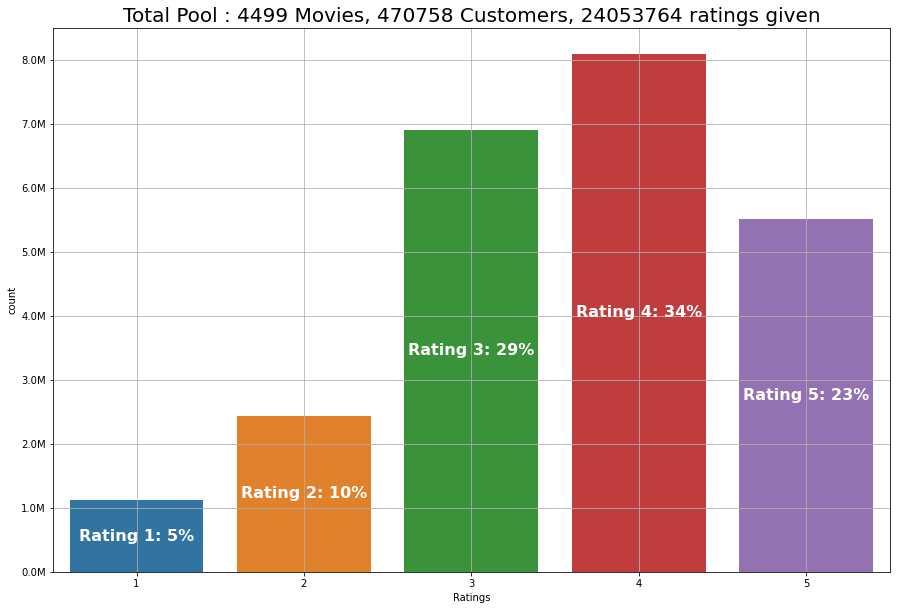

In [25]:
plt.figure(figsize = (15, 10))
ax = sns.countplot(x="Ratings", data=Final_Data)
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
plt.title(f'Total Pool : {movie_count} Movies, {customer_count} Customers, {rating_count} ratings given', fontsize =20)
plt.grid(True)

i = 0
for p in ax.patches:
    i += 1
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    #print(p,x,y,width, height)
    ax.annotate(f'Rating {i}: {height/rating_count:.0%}', (x + width/2, y + height/2), ha='center', va="center", color="white", fontsize=16, fontweight="bold")

#### Number of movies in dataset with number of ratings for every movie

In [20]:
#number of movies in dataset with number of ratings for every movie
per_movie_rater_count = Final_Data.groupby('MovieID')['MovieID'].agg(['count'])
per_movie_rater_count

,count
MovieID,
1,547
2,145
3,2012
4,142
5,1140
...,...
4495,614
4496,9519
4497,714


In [21]:
# Saving the session till data import
# import dill
# dill.dump_session('dataImport.db')
# import dill
# dill.load_session('dataImport.db')

#### Split the Netflix movie dataset into Train and Test data with 80:20 ratio

In [32]:
#If not already present, then create, else read from existing pickle file

if not os.path.isfile("TrainData.pkl"):
    Final_Data.iloc[:int(Final_Data.shape[0]*0.80)].to_pickle("TrainData.pkl")
    Train_Data = pd.read_pickle("TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
else:
    Train_Data = pd.read_pickle("TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)

if not os.path.isfile("TestData.pkl"):
    Final_Data.iloc[int(Final_Data.shape[0]*0.80):].to_pickle("TestData.pkl")
    Test_Data = pd.read_pickle("TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)
else:
    Test_Data = pd.read_pickle("TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)

#### Training Data Statistics

In [34]:
print("Total Train Data:")
print("Total number of movie ratings in train data = "+str(Train_Data.shape[0]))
print("Number of unique users in train data = "+str(len(np.unique(Train_Data["CustID"]))))
print("Number of unique movies in train data = "+str(len(np.unique(Train_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Train_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Train_Data["MovieID"].values)))

Total Train Data:
Total number of movie ratings in train data = 19243011
Number of unique users in train data = 389223
Number of unique movies in train data = 4403
Highest value of a User ID = 2649429
Highest value of a Movie ID = 4499


#### Test data statistics

In [36]:
print("Total Test Data:")
print("Total number of movie ratings in Test data = "+str(Test_Data.shape[0]))
print("Number of unique users in Test data = "+str(len(np.unique(Test_Data["CustID"]))))
print("Number of unique movies in Test data = "+str(len(np.unique(Test_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Test_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Test_Data["MovieID"].values)))

Total Test Data:
Total number of movie ratings in Test data = 4810753
Number of unique users in Test data = 302727
Number of unique movies in Test data = 4497
Highest value of a User ID = 2649429
Highest value of a Movie ID = 4499


## Exploratory Data Analysis (EDA) on Training Dataset

In [39]:
#Finding the days of every date
Train_Data["DayOfWeek"] = Train_Data.Date.dt.strftime("%A")

In [44]:
Train_Data.head(10)

,MovieID,CustID,Ratings,Date,DayOfWeek
0,1798,510180,5,1999-11-11,Thursday
1,2866,510180,3,1999-11-11,Thursday
2,3730,510180,4,1999-11-11,Thursday
3,3870,510180,2,1999-11-11,Thursday
4,1367,510180,5,1999-11-11,Thursday
5,2948,510180,3,1999-12-06,Monday
6,3421,510180,3,1999-12-06,Monday
7,2478,510180,3,1999-12-06,Monday
8,1615,122223,3,1999-12-08,Wednesday
9,2780,122223,3,1999-12-08,Wednesday


#### Number of ratings per month

C:\Users\ruchi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


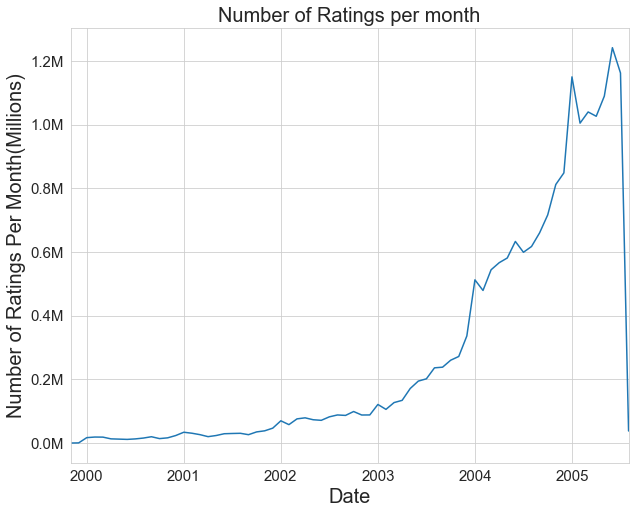

In [107]:
plt.figure(figsize = (10,8))
ax = Train_Data.resample("M", on = "Date")["Ratings"].count().plot()
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
ax.set_title("Number of Ratings per month", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Number of Ratings Per Month(Millions)", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.show()

##### We can see that there is a massive growth of Netflix during the period 2003–2006.

#### Analysis of Ratings given by user 

In [108]:
no_of_rated_movies_per_user = Train_Data.groupby(by = "CustID")["Ratings"].count().sort_values(ascending = False)

In [122]:
no_of_rated_movies_per_user

CustID
305344     4326
2439493    4017
387418     3881
1639792    2500
1461435    2339
           ... 
2604554       1
1603923       1
1603917       1
712499        1
1053710       1
Name: Ratings, Length: 389223, dtype: int64

#### Plotting PDF and CDF for the above ratings by users

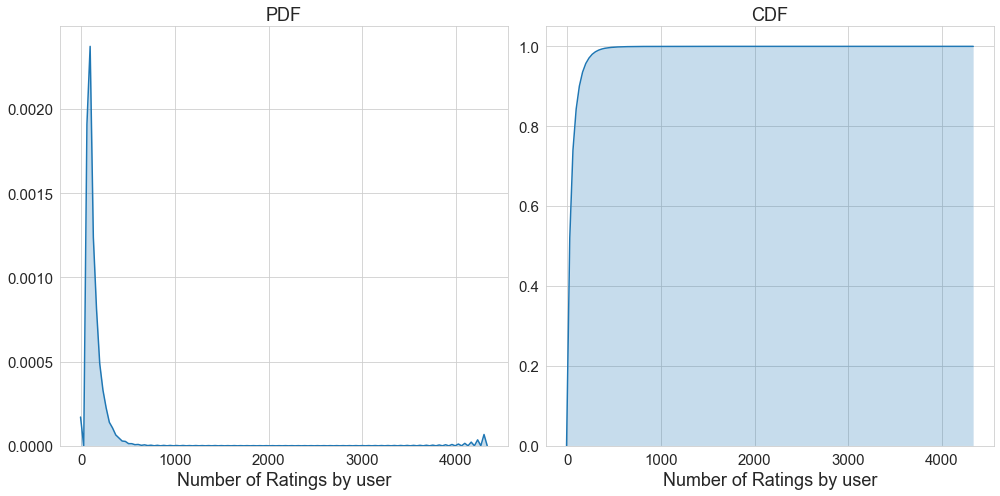

In [111]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

#### From above PDF plot, we see that almost all of the users give very few ratings. There are very few users who's ratings count is high.
##### Similarly, above CDF graph shows that almost 99% of users give very few ratings.

### Analysis of Ratings Per Movie

In [114]:
no_of_ratings_per_movie = Train_Data.groupby(by = "MovieID")["Ratings"].count().sort_values(ascending = False)

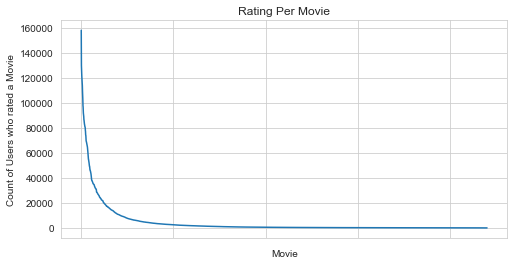

In [118]:
fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('Rating Per Movie')
plt.xlabel('Movie')
plt.ylabel('Count of Users who rated a Movie')
ax.set_xticklabels([])

plt.show()

#### This plot being very skewed tells us that there are some movies which are very popular and were rated by many users as compared to other movies as shown below.

In [121]:
no_of_ratings_per_movie.sort_values(ascending=False)

MovieID
1905    158267
4432    130331
571     130038
2452    127212
3860    127051
         ...  
887          1
2280         1
1072         1
1416         1
2534         1
Name: Ratings, Length: 4403, dtype: int64

In [1]:
# import dill
# dill.dump_session('dataEDA.db')
import dill
dill.load_session('dataEDA.db')

C:\Users\ruchi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


C:\Users\ruchi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


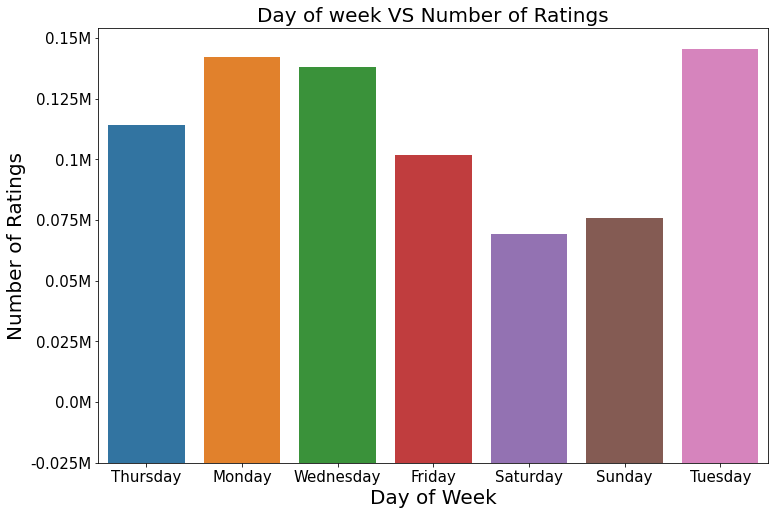

In [3]:
fig = plt.figure(figsize = (12, 8))

axes = sns.countplot(x = "DayOfWeek", data = Train_Data)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
axes.tick_params(labelsize = 15)

plt.show()

In [4]:
average_ratings_dayofweek = Train_Data.groupby(by = "DayOfWeek")["Ratings"].mean()
print("Average Ratings on Day of Weeks")
print(average_ratings_dayofweek)

Average Ratings on Day of Weeks
DayOfWeek
Friday       3.576426
Monday       3.573257
Saturday     3.585673
Sunday       3.588731
Thursday     3.577798
Tuesday      3.570347
Wednesday    3.578739
Name: Ratings, dtype: float64


## Construct USER-ITEM Sparse Matrix using the training dataset

In [17]:
startTime = datetime.now()
print("Constructing USER-ITEM sparse matrix for train Data")
if os.path.isfile("TrainUISparseData.npz"):
    print("Sparse Data is already present, no need to create further. Loading Sparse Matrix")
    TrainUISparseData = sparse.load_npz("TrainUISparseData.npz")
    print("Shape of Train Sparse matrix = "+str(TrainUISparseData.shape))
    
else:
    print("We are creating sparse data")
    TrainUISparseData = sparse.csr_matrix((Train_Data.Ratings, (Train_Data.CustID, Train_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TrainUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("TrainUISparseData.npz", TrainUISparseData)
    print("Done\n")

print(datetime.now() - startTime)

Constructing USER-ITEM sparse matrix for train Data
Sparse Data is already present, no need to create further. Loading Sparse Matrix
Shape of Train Sparse matrix = (2649430, 4500)
0:00:02.310465


In [18]:
startTime = datetime.now()
print("Creating USER-ITEM sparse matrix for test Data")
if os.path.isfile("TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz("TestUISparseData.npz")
    print("Shape of Test Sparse Matrix = "+str(TestUISparseData.shape))
else:
    print("We are creating sparse data")
    TestUISparseData = sparse.csr_matrix((Test_Data.Ratings, (Test_Data.CustID, Test_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TestUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("TestUISparseData.npz", TestUISparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER-ITEM sparse matrix for test Data
We are creating sparse data
Creation done. Shape of sparse matrix = (2649430, 4500)
Saving it into disk for furthur usage.
Done

0:00:09.607733


If you can see above that the shape of both train and test sparse matrices are same, furthermore, how come this shape of sparse matrix has arrived:
Shape of sparse matrix depends on highest value of User ID and highest value of Movie ID. 

Now the user whose user ID is highest is present in both train data and test data. Similarly, the movie whose movie ID is highest is present in both train data and test data. Hence, shape of both train and test sparse matrices are same.

In [19]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 99.83859831485766% 


In [20]:
rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()

print("Sparsity Of Test matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Test matrix : 99.95964957661752% 


#### Finding Averages of movie ratings

In [21]:
def getAverageRatings(sparseMatrix, if_user):
    ax = 1 if if_user else 0
    
    #axis = 1 means rows and axis = 0 means columns 
    sumOfRatings = sparseMatrix.sum(axis = ax).A1  #this will give an array of sum of all the ratings of user if axis = 1 else 
    
    #sum of all the ratings of movies if axis = 0
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1
    #this will give a boolean True or False array, and True means 1 and False means 0, and 
    #further we are summing it to get the count of all the non-zero cells means length of non-zero cells
    
    rows, cols = sparseMatrix.shape
    
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    return averageRatings

#### Global Average Rating

In [22]:
Global_Average_Rating = TrainUISparseData.sum()/TrainUISparseData.count_nonzero()
print("Global Average Rating {}".format(Global_Average_Rating))

Global Average Rating 3.577584765710522


#### Average Rating Per User

In [23]:
AvgRatingUser = getAverageRatings(TrainUISparseData, True)

In [25]:
print("Average rating of user 50 = {}".format(AvgRatingUser[25]))

Average rating of user 50 = 3.5


#### Average Rating Per Movie

In [26]:
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)

In [33]:
print("Average rating of movie 3500 = {}".format(AvgRatingMovie[3500]))

Average rating of movie 3500 = 3.615198810850985


#### PDF and CDF of Average Ratings of Users and Movies

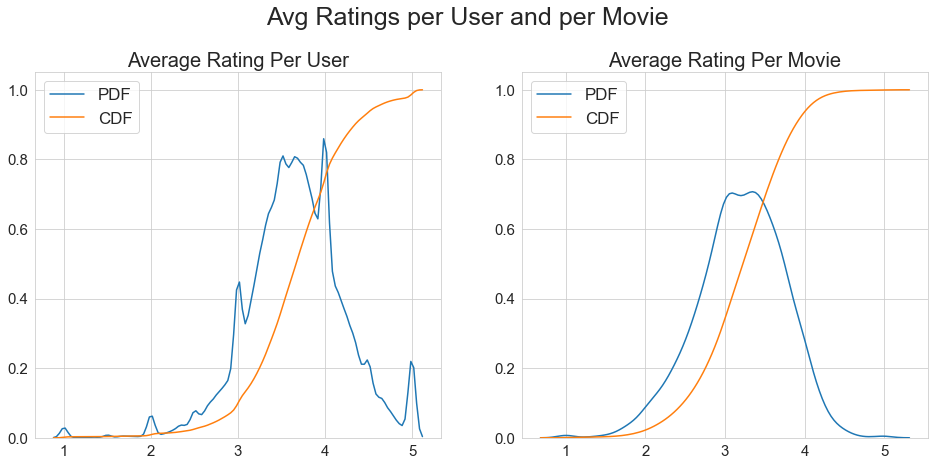

In [34]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 7))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=25)

user_average = [rats for rats in AvgRatingUser.values()]
sns.distplot(user_average, hist = False, ax = axes[0], label = "PDF")
sns.kdeplot(user_average, cumulative = True, ax = axes[0], label = "CDF")
axes[0].set_title("Average Rating Per User", fontsize=20)
axes[0].tick_params(labelsize = 15)
axes[0].legend(loc='upper left', fontsize = 17)

movie_average = [ratm for ratm in AvgRatingMovie.values()]
sns.distplot(movie_average, hist = False, ax = axes[1], label = "PDF")
sns.kdeplot(movie_average, cumulative = True, ax = axes[1], label = "CDF")
axes[1].set_title("Average Rating Per Movie", fontsize=20)
axes[1].tick_params(labelsize = 15)
axes[1].legend(loc='upper left', fontsize = 17)

plt.subplots_adjust(wspace=0.2, top=0.85)
plt.show()

#### Number of Movies and Users in the dataset (Cold Start Problem)

In [36]:
total_users = len(np.unique(Final_Data["CustID"]))
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users
                  
print("Total number of Users = {}".format(total_users))
print("Number of Users in train data= {}".format(train_users))
print("Number of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total number of Users = 470758
Number of Users in train data= 389223
Number of Users not present in train data = 81535(17.0%)


In [37]:
total_movies = len(np.unique(Final_Data["MovieID"]))
train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies
                  
print("Total number of Movies = {}".format(total_movies))
print("Number of Movies in train data= {}".format(train_movies))
print("Number of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total number of Movies = 4499
Number of Movies in train data= 4403
Number of Movies not present in train data = 96(2.0%)


### Computing the similarity matrix (Movie-Movie)

In [39]:
start = datetime.now()

if not os.path.isfile("m_m_similarity.npz"):
    print("Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...")
    
    m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output = False)
    print("Done")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    print("Storing the Movie Similarity matrix on disk for further usage")
    sparse.save_npz("m_m_similarity.npz", m_m_similarity)
else:
    print("File exists in the disk. Loading the file...")
    m_m_similarity = sparse.load_npz("../Data/m_m_similarity.npz")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    
print(datetime.now() - start)

Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...
Done
Dimension of Matrix = (4500, 4500)
Storing the Movie Similarity matrix on disk for further usage
0:00:57.107732


#### Testing the Movie-Movie Similarity on the dataset

In [40]:
movie_ids = np.unique(m_m_similarity.nonzero())

In [41]:
# Creates a dictionary object of all movies similar to every movie
similar_movies_dict = dict()
for movie in movie_ids:
    smlr = np.argsort(-m_m_similarity[movie].toarray().ravel())[1:100]
    similar_movies_dict[movie] = smlr

In [42]:
movie_titles_df = pd.read_csv("movie_titles.csv",sep = ",", header = None, names=['MovieID', 'Year_of_Release', 'Movie_Title'], index_col = "MovieID", encoding = "iso8859_2")

In [43]:
movie_titles_df.head()

,Year_of_Release,Movie_Title
MovieID,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


#### Finding Similar movies based on Sparse Data

In [44]:
str(movie_titles_df.loc[289][1])

'The Avengers'

In [45]:
movieID_TA = 289

print("Name of the movie -------> "+str(movie_titles_df.loc[movieID_TA][1]))

print("Number of ratings by users for movie {} is {}".format(movie_titles_df.loc[movieID_TA][1], TrainUISparseData[:,movieID_TA].getnnz()))

print("Number of similar movies to {} is {}".format(movie_titles_df.loc[movieID_TA][1], m_m_similarity[movieID_TA].count_nonzero()))

Name of the movie -------> The Avengers
Number of ratings by users for movie The Avengers is 3838
Number of similar movies to The Avengers is 4389


In [46]:
all_similar = sorted(m_m_similarity[movieID_TA].toarray().ravel(), reverse = True)[1:]

similar_100 = all_similar[:101]

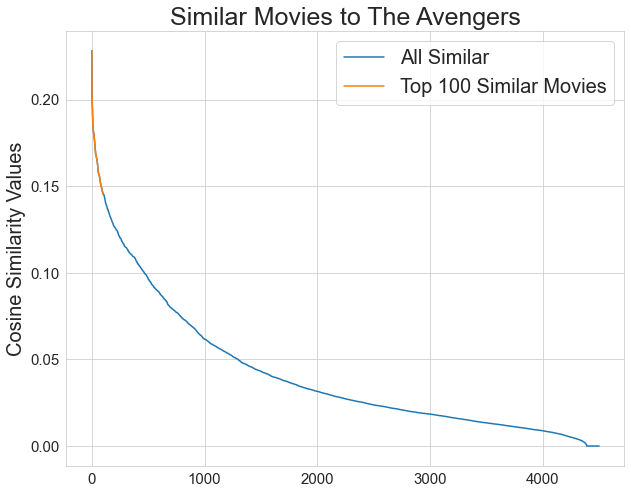

In [47]:
plt.figure(figsize = (10, 8))
plt.plot(all_similar, label = "All Similar")
plt.plot(similar_100, label = "Top 100 Similar Movies")
plt.title("Similar Movies to The Avengers", fontsize = 25)
plt.ylabel("Cosine Similarity Values", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.legend(fontsize = 20)
plt.show()

#### Finding movies similar to The Avengers

In [48]:
movie_titles_df.loc[similar_movies_dict[movieID_TA][:10]]

,Year_of_Release,Movie_Title
MovieID,,
993,1994.0,The Shadow
548,1991.0,Hudson Hawk
2163,1999.0,Mystery Men
58,1996.0,Dragonheart
4171,1996.0,Mars Attacks!
393,1998.0,The Replacement Killers
1693,1998.0,Sphere
811,1992.0,The Lawnmower Man
686,2000.0,Bedazzled


#### This confirms that the movie-movie similarity matrix is working.

### Machine Learning Models 

In [50]:
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies):
    startTime = datetime.now()
    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15)
    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(userS)+1, max(movieS)+1))
    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(path, sparse_sample)
    print("Done")
    print("Shape of Sparse Sampled Matrix = "+str(sparse_sample.shape))
    
    print(datetime.now() - start)
    return sparse_sample

#### Creating Sample Sparse Matrix for Train Data

In [116]:
path = "TrainUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 4000, 400)
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Train Sample Sparse Matrix = "+str(train_sample_sparse.shape))
    data_csr_size = train_sample_sparse.data.size/(1024**2)
    print('Size of sparse csr_matrix: '+ '%3.2f' %data_csr_size + ' MB')

File is already present in the disk. Loading the file...
File loading done.
Shape of Train Sample Sparse Matrix = (2649094, 4486)
Size of sparse csr_matrix: 0.02 MB


#### Creating Sample Sparse Matrix for Test Data

In [52]:
path = "TestUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200)
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Test Sample Sparse Matrix = "+str(test_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Done
Shape of Sparse Sampled Matrix = (2648854, 4483)
0:20:00.089954


#### Finding Averages of all movie ratings from Sampled Train 

In [53]:
print("Global average of all movies ratings in Train Sample Sparse is {}".format(np.round((train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2)))

Global average of all movies ratings in Train Sample Sparse is 3.62


#### Finding Average of ratings for a movie

In [59]:
globalAvgMovies = getAverageRatings(train_sample_sparse, False)
print("Average move rating for movie 3433 is {}".format(globalAvgMovies[3433]))

Average move rating for movie 3433 is 3.4338842975206614


#### Finding Average rating per User

In [62]:
globalAvgUsers = getAverageRatings(train_sample_sparse, True)
print("Average user rating for user 4229 is {}".format(globalAvgUsers[4229]))

Average user rating for user 4229 is 3.7142857142857144


#### Featurizing data

In [63]:
print("No of ratings in Our Sampled train matrix is : {}".format(train_sample_sparse.count_nonzero()))
print("No of ratings in Our Sampled test matrix is : {}".format(test_sample_sparse.count_nonzero()))

No of ratings in Our Sampled train matrix is : 22326
No of ratings in Our Sampled test matrix is : 1358


#### Featurizing data for regression problem

#### Featurizing Train Data

In [64]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(train_sample_sparse)

In [24]:
if os.path.isfile("Train_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Train csv file for {} rows".format(len(sample_train_ratings)))
    with open("Train_Regression.csv", mode = "w") as data:
        count = 0
        for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            row = list()
            row.append(user)  #appending user ID
            row.append(movie) #appending movie ID
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating

#----------------------------------Ratings given to "movie" by top 5 similar users with "user"--------------------#
            similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
            row.extend(top_similar_user_ratings)
            
 #----------------------------------Ratings given by "user" to top 5 similar movies with "movie"------------------#
            similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
            similar_movies_indices = np.argsort(-similar_movies)[1:]
            similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
            row.extend(top_similar_movie_ratings)
            
 #----------------------------------Appending "user" average, "movie" average & rating of "user""movie"-----------#
            row.append(globalAvgUsers[user])
            row.append(globalAvgMovies[movie])
            row.append(rating)
            
#-----------------------------------Converting rows and appending them as comma separated values to csv file------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 2000 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_train_ratings), (datetime.now() - startTime)))

File is already present in your disk. You do not have to prepare it again.


In [66]:
Train_Reg = pd.read_csv("Train_Regression.csv", names = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,4315,70,3.622772,4.0,3.0,3.333333,3.333333,3.333333,4.0,4.0,4.0,5.0,4.0,4.080000,3.333333,3
1,303087,70,3.622772,4.0,3.0,3.333333,3.333333,3.333333,3.0,3.0,2.0,3.0,5.0,3.322581,3.333333,3
2,1287490,70,3.622772,3.0,3.0,3.333333,3.333333,3.333333,5.0,5.0,3.0,5.0,1.0,3.729730,3.333333,4
3,508662,74,3.622772,4.0,3.0,4.000000,4.000000,4.000000,5.0,5.0,4.0,5.0,5.0,3.842105,4.000000,5
4,2335663,74,3.622772,5.0,3.0,4.000000,4.000000,4.000000,2.0,5.0,5.0,4.0,3.0,3.833333,4.000000,4


In [67]:
print("Number of nan Values = "+str(Train_Reg.isnull().sum().sum()))

Number of nan Values = 0


In [68]:
print("Shape of Train DataFrame = {}".format(Train_Reg.shape))

Shape of Train DataFrame = (22326, 16)


User_ID: ID of a this User

Movie_ID: ID of a this Movie

Global_Average: Global Average Rating

Ratings given to this Movie by top 5 similar users with this User: (SUR1, SUR2, SUR3, SUR4, SUR5)

Ratings given by this User to top 5 similar movies with this Movie: (SMR1, SMR2, SMR3, SMR4, SMR5)

User_Average: Average Rating of this User

Movie_Average: Average Rating of this Movie

Rating: Rating given by this User to this Movie

#### Featurizing Test Data

In [69]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(test_sample_sparse)

In [70]:
if os.path.isfile("Test_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Test csv file for {} rows".format(len(sample_test_ratings)))
    with open("Test_Regression.csv", mode = "w") as data:
        count = 0
        for user, movie, rating in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            row = list()
            row.append(user)  #appending user ID
            row.append(movie) #appending movie ID
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating

#-----------------------------Ratings given to "movie" by top 5 similar users with "user"-------------------------#
            try:
                similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
                similar_users_indices = np.argsort(-similar_users)[1:]
                similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
                top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
                top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
                row.extend(top_similar_user_ratings)   
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Ratings given by "user" to top 5 similar movies with "movie"-----------------------#
            try:
                similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
                similar_movies_indices = np.argsort(-similar_movies)[1:]
                similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
                top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
                top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
                #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" 
                #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
                row.extend(top_similar_movie_ratings)
            #########Cold Start Problem, for a new user or a new movie#########
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Appending "user" average, "movie" average & rating of "user""movie"----------------#
            try:        
                row.append(globalAvgUsers[user])
            except (KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            try:
                row.append(globalAvgMovies[movie])
            except(KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            row.append(rating)
            
#------------------------------Converting rows and appending them as comma separated values to csv file-----------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 100 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_test_ratings), (datetime.now() - startTime)))

Preparing Test csv file for 1358 rows
Done for 100. Time elapsed: 0:00:21.653039
Done for 200. Time elapsed: 0:00:43.875049
Done for 300. Time elapsed: 0:01:05.982049
Done for 400. Time elapsed: 0:01:28.103052
Done for 500. Time elapsed: 0:01:50.074999
Done for 600. Time elapsed: 0:02:12.217051
Done for 700. Time elapsed: 0:02:34.691051
Done for 800. Time elapsed: 0:02:56.918041
Done for 900. Time elapsed: 0:03:19.228051
Done for 1000. Time elapsed: 0:03:41.534035
Done for 1100. Time elapsed: 0:04:03.492048
Done for 1200. Time elapsed: 0:04:25.418038
Done for 1300. Time elapsed: 0:04:47.824999
Total Time for 1358 rows = 0:05:00.710036


In [71]:
Test_Reg = pd.read_csv("Test_Regression.csv", names = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,777147,5,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,5
1,1748471,5,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,5
2,1934002,5,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,1
3,2189335,5,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,4
4,2411773,5,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3.622772,3


In [72]:
print("Number of nan Values = "+str(Test_Reg.isnull().sum().sum()))

Number of nan Values = 0


In [73]:
print("Shape of Test DataFrame = {}".format(Test_Reg.shape))

Shape of Test DataFrame = (1358, 16)


### Transforming Data for Surprise Models

### Transforming Train Data

In [74]:
Train_Reg[['User_ID', 'Movie_ID', 'Rating']].head(5)

,User_ID,Movie_ID,Rating
0,4315,70,3
1,303087,70,3
2,1287490,70,4
3,508662,74,5
4,2335663,74,4


In [76]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(Train_Reg[['User_ID', 'Movie_ID', 'Rating']], reader)

trainset = data.build_full_trainset()

#### Transforming Test Data

In [78]:
testset = list(zip(Test_Reg["User_ID"].values, Test_Reg["Movie_ID"].values, Test_Reg["Rating"].values))

In [79]:
testset[:5]

[(777147, 5, 5),
 (1748471, 5, 5),
 (1934002, 5, 1),
 (2189335, 5, 4),
 (2411773, 5, 3)]

In [5]:
# import dill
# dill.dump_session('MLModels.db')
import dill
dill.load_session('MLModels.db')

C:\Users\ruchi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Applying Machine Learning Models
Creating Utility functions and XGBoost function

In [7]:
error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [8]:
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]))
    error_table.reset_index(drop = True, inplace = True)

In [9]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

In [10]:
def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [14]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse, mape

In [11]:
def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):
    startTime = datetime.now()
    train_result = dict()
    test_result = dict()
    
    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
    clf.fit(x_train, y_train)
    
    print("-"*50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE = {}".format(rmse_train))
    print("MAPE = {}".format(mape_train))
    print("-"*50)
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}
    
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE = {}".format(rmse_test))
    print("MAPE = {}".format(mape_test))
    print("-"*50)
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}
        
    print("Time Taken = "+str(datetime.now() - startTime))
    
    make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)
    
    return train_result, test_result

In [12]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def run_surprise(algo, trainset, testset, model_name):
    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    #You can check out above function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    
#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    #You can check out "trainset.build_testset()" function at "https://surprise.readthedocs.io/en/stable/FAQ.html#can-i-use-my-own-dataset-with-surprise-and-can-it-be-a-pandas-dataframe" in 
    #"How to get accuracy measures on the training set" section
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    print("-"*50)
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}
    
#-----------------Evaluating Test Data------------------#
    print("TEST DATA")
    test_pred = algo.test(testset)
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    print("-"*50)
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}
    
    print("Time Taken = "+str(datetime.now() - startTime))
    
    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    
    return train, test

### 1. XGBoost
Collaborative filtering is based only on a user’s history compared to that of users with a similar history.
https://xgboost.readthedocs.io/en/latest/

In [15]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")

model_train_evaluation["XGBoost_13"] = train_result
model_test_evaluation["XGBoost_13"] = test_result

[20:33:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


--------------------------------------------------
TRAIN DATA
RMSE = 0.6115289509187177
MAPE = 16.398698091506958
--------------------------------------------------
TEST DATA
RMSE = 1.22790192023578
MAPE = 30.27111559096761
--------------------------------------------------
Time Taken = 0:00:00.947025


C:\Users\ruchi\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


### 2. Matrix Factorization SVD

Matrix factorization algorithms work by decomposing the user-movie interaction matrix into the product of two lower dimensionality rectangular matrices, say U and M. The decomposition is done in such a way that the product results in almost similar values to the user-movie interaction matrix. Here, U represents the user matrix, M represents the movie matrix, n is the number of users, and m is the number of movies.
http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

In [16]:
param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}   #here, n_factors is the equivalent to dimension 'd' when matrix 'A'
#is broken into 'b' and 'c'. So, matrix 'A' will be of dimension n*m. So, matrices 'b' and 'c' will be of dimension n*d and m*d.

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9453220512021484
{'n_factors': 7}


In [17]:
algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVD")

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.8530107553010928
MAPE = 25.893075845302825
--------------------------------------------------
TEST DATA
RMSE = 1.0457877085274596
MAPE = 31.904487821009543
--------------------------------------------------
Time Taken = 0:00:00.490962


### 3. Matrix Factorization SVDpp with implicit feedback

In [20]:
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9445913070753368
{'n_factors': 10, 'lr_all': 0.006}


In [21]:
algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.7910620110093817
MAPE = 23.764017375323547
--------------------------------------------------
TEST DATA
RMSE = 1.0478718931319626
MAPE = 31.930540740289082
--------------------------------------------------
Time Taken = 0:00:04.802979


### Comparing all ML Models

In [22]:
final_error_table = error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)

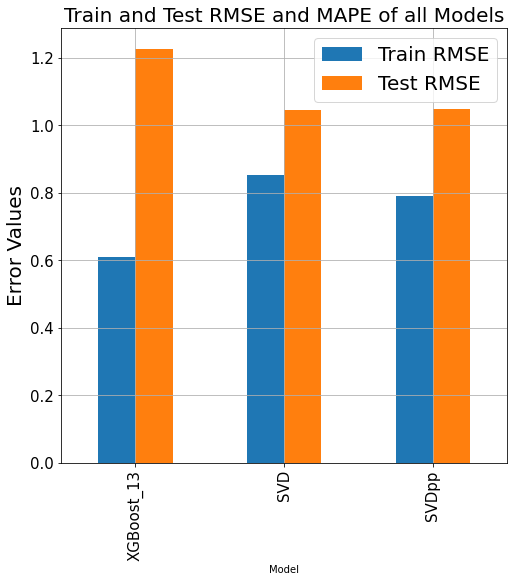

In [23]:
final_error_table.plot(x = "Model", kind = "bar", figsize = (8, 8), grid = True, fontsize = 15)
plt.title("Train and Test RMSE and MAPE of all Models", fontsize = 20)
plt.ylabel("Error Values", fontsize = 20)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 20)
plt.show()

In [30]:
error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)

,Model,Train RMSE,Test RMSE
0,XGBoost_13,0.611529,1.227902
1,SVD,0.853011,1.045788
2,SVDpp,0.791062,1.047872
